This is pulled from https://github.com/snap-stanford/ogb/tree/master/examples/lsc/pcqm4m

dependencies:
- install rdkit (I used conda) https://www.rdkit.org/docs/Install.html
1. conda create -c conda-forge -n my-rdkit-env rdkit
2. conda activate my-rdkit-env
3. cd [anaconda folder]/bin
4. source activate my-rdkit-env

- install ogb, torch and pytorch-geometric

- run the main-gnn.py code to download the dataset, extract and train (see the readme.md). I could finish extracting because my RAM wasn't enough. If you face the some problem, use this notebook to extract just a handful of the dataset. This code is taken from 

In [1]:
import os
import os.path as osp
import shutil
from ogb.utils import smiles2graph
from ogb.utils.torch_util import replace_numpy_with_torchtensor
from ogb.utils.url import decide_download, download_url, extract_zip
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

In [2]:
"""
WARNING: THIS IS NOT A GOOD PRACTICE AS I UPLOADED THE FILES TO GITHUB. CAN REMOVE LATER
my folder structure looks like (obtained from running main_gnn)
dataset/
    pcqm4m_kddcup2021/
        mapping/
        processed/
        raw/
            data.csv.gz
"""

ROOT = "dataset/pcqm4m_kddcup2021"
filename = "{}/{}".format(ROOT, "raw/data.csv.gz")
data_df = pd.read_csv(filename)
data_df

,idx,smiles,homolumogap
0,0,Cc1ccc(cc1)C1C=c2cnccc2=NC1=O,3.047675
1,1,COc1cc(OC)ccc1C=CN(C(=O)C)C,4.410966
2,2,C=CCN(C(=O)C)C=Cc1ccccc1C,4.639541
3,3,C=CCN(C(=O)C)C=Cc1ccccc1F,4.492600
4,4,C=CCN(C(=O)C)C=Cc1ccccc1Cl,4.612330
...,...,...,...
3803448,3803448,O=N(=O)c1ccc(c(c1)N(=O)=O)Cl,NaN
3803449,3803449,NCC(=O)COP(=O)(O)O,NaN
3803450,3803450,CC(CN)O,NaN
3803451,3803451,OC1C=CC=C(C1O)C(=O)O,NaN


In [3]:
smiles_list = data_df['smiles']
homolumogap_list = data_df['homolumogap']

In [4]:
# THIS IS TAKEN FROM ogb file extraction 

print('Converting SMILES strings into graphs...')
data_list = []
for i in tqdm(range(len(smiles_list))):
    data = Data()

    smiles = smiles_list[i]
    homolumogap = homolumogap_list[i]
    graph = smiles2graph(smiles)

    assert(len(graph['edge_feat']) == graph['edge_index'].shape[1])
    assert(len(graph['node_feat']) == graph['num_nodes'])

    data.__num_nodes__ = int(graph['num_nodes'])
    data.edge_index = torch.from_numpy(graph['edge_index']).to(torch.int64)
    data.edge_attr = torch.from_numpy(graph['edge_feat']).to(torch.int64)
    data.x = torch.from_numpy(graph['node_feat']).to(torch.int64)
    data.y = torch.Tensor([homolumogap])

    data_list.append(data)
    
    """
    EARLY BREAK HERE BEFORE EVERYTHING IS COMPLETED
    OTHERWISE IT TAKES LOTS OF RAM
    """
    if i == 10:
        break


  0%|          | 10/3803453 [00:00<38:28, 1647.93it/s]

Converting SMILES strings into graphs...


In [5]:
# assume no pre-transformation
pre_transform = None

In [6]:
# double-check prediction target
split_dict = replace_numpy_with_torchtensor(torch.load(osp.join(ROOT, 'split_dict.pt')))
    
"""
TURN OFF ASSERTION SINCE WE ONLY WORK WITH A SUBSET
"""
# assert(all([not torch.isnan(data_list[i].y)[0] for i in split_dict['train']]))
# assert(all([not torch.isnan(data_list[i].y)[0] for i in split_dict['valid']]))
# assert(all([torch.isnan(data_list[i].y)[0] for i in split_dict['test']]))

if pre_transform is not None:
    data_list = [self.pre_transform(data) for data in data_list]

# why do we combine everything into a single data
data, slices = InMemoryDataset.collate(data_list)

# print('Saving...')
# torch.save((data, slices), self.processed_paths[0])

In [7]:
# print('Saving...')
# saveFilename = "{}/{}".format(ROOT, "processed/datatorch")
# torch.save((data, slices), saveFilename)


In [8]:
data_list

[Data(edge_attr=[40, 3], edge_index=[2, 40], x=[18, 9], y=[1]),
 Data(edge_attr=[34, 3], edge_index=[2, 34], x=[17, 9], y=[1]),
 Data(edge_attr=[32, 3], edge_index=[2, 32], x=[16, 9], y=[1]),
 Data(edge_attr=[32, 3], edge_index=[2, 32], x=[16, 9], y=[1]),
 Data(edge_attr=[32, 3], edge_index=[2, 32], x=[16, 9], y=[1]),
 Data(edge_attr=[30, 3], edge_index=[2, 30], x=[15, 9], y=[1]),
 Data(edge_attr=[30, 3], edge_index=[2, 30], x=[15, 9], y=[1]),
 Data(edge_attr=[28, 3], edge_index=[2, 28], x=[14, 9], y=[1]),
 Data(edge_attr=[26, 3], edge_index=[2, 26], x=[13, 9], y=[1]),
 Data(edge_attr=[32, 3], edge_index=[2, 32], x=[15, 9], y=[1]),
 Data(edge_attr=[30, 3], edge_index=[2, 30], x=[15, 9], y=[1])]

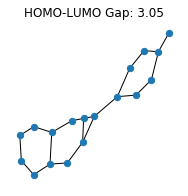

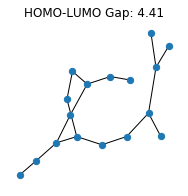

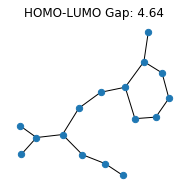

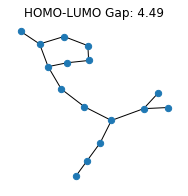

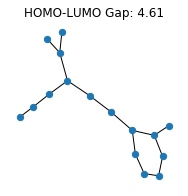

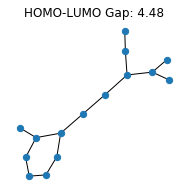

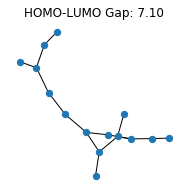

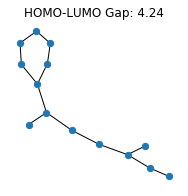

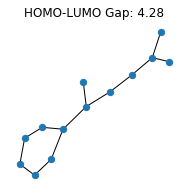

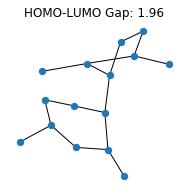

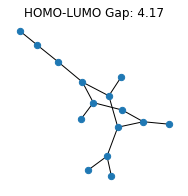

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

for i in range(11):
    
    _data = data_list[i]
    edges = _data.edge_index.T.tolist()
    edges = np.array(edges)

    G = nx.Graph()
    G.add_edges_from(edges)

    plt.figure(figsize=(3, 3))
    plt.title("HOMO-LUMO Gap: {0:.2f}".format(_data.y.tolist()[0]))
    nx.draw(G, node_size=40)
    plt.show()

## debug

don't need to care about things below here

In [10]:
# from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

In [11]:
# !pwd

In [12]:
# import os
# import os.path as osp
# import shutil
# from ogb.utils import smiles2graph
# from ogb.utils.torch_util import replace_numpy_with_torchtensor
# from ogb.utils.url import decide_download, download_url, extract_zip
# import pandas as pd
# import numpy as np
# from tqdm import tqdm
# import torch

# from torch_geometric.data import InMemoryDataset
# from torch_geometric.data import Data

# class PygPCQM4MDataset(InMemoryDataset):
#     def __init__(self, root = 'dataset', smiles2graph = smiles2graph, transform=None, pre_transform = None):
#         '''
#             Pytorch Geometric PCQM4M dataset object
#                 - root (str): the dataset folder will be located at root/pcqm4m_kddcup2021
#                 - smiles2graph (callable): A callable function that converts a SMILES string into a graph object
#                     * The default smiles2graph requires rdkit to be installed
#         '''

#         self.original_root = root
#         self.smiles2graph = smiles2graph
#         self.folder = osp.join(root, 'pcqm4m_kddcup2021')
#         self.version = 1
        
#         # Old url hosted at Stanford
#         # self.url = f'http://ogb-data.stanford.edu/data/lsc/pcqm4m_kddcup2021.zip'
#         # New url hosted by DGL team at AWS--much faster to download
#         self.url = 'https://dgl-data.s3-accelerate.amazonaws.com/dataset/OGB-LSC/pcqm4m_kddcup2021.zip'

#         # check version and update if necessary
#         if osp.isdir(self.folder) and (not osp.exists(osp.join(self.folder, f'RELEASE_v{self.version}.txt'))):
#             print('PCQM4M dataset has been updated.')
#             if input('Will you update the dataset now? (y/N)\n').lower() == 'y':
#                 shutil.rmtree(self.folder)

#         super(PygPCQM4MDataset, self).__init__(self.folder, transform, pre_transform)

#         self.data, self.slices = torch.load(self.processed_paths[0])

#     @property
#     def raw_file_names(self):
#         return 'data.csv.gz'

#     @property
#     def processed_file_names(self):
#         return 'geometric_data_processed.pt'

#     def download(self):
#         if decide_download(self.url):
#             path = download_url(self.url, self.original_root)
#             extract_zip(path, self.original_root)
#             os.unlink(path)
#         else:
#             print('Stop download.')
#             exit(-1)

#     def process(self):
#         data_df = pd.read_csv(osp.join(self.raw_dir, 'data.csv.gz'))
#         smiles_list = data_df['smiles']
#         homolumogap_list = data_df['homolumogap']

#         print('Converting SMILES strings into graphs...')
#         data_list = []
#         for i in tqdm(range(len(smiles_list))):
#             data = Data()

#             smiles = smiles_list[i]
#             homolumogap = homolumogap_list[i]
#             graph = self.smiles2graph(smiles)
            
#             assert(len(graph['edge_feat']) == graph['edge_index'].shape[1])
#             assert(len(graph['node_feat']) == graph['num_nodes'])

#             data.__num_nodes__ = int(graph['num_nodes'])
#             data.edge_index = torch.from_numpy(graph['edge_index']).to(torch.int64)
#             data.edge_attr = torch.from_numpy(graph['edge_feat']).to(torch.int64)
#             data.x = torch.from_numpy(graph['node_feat']).to(torch.int64)
#             data.y = torch.Tensor([homolumogap])

#             data_list.append(data)
            
#             if i == 10:
#                 break
                
#         # double-check prediction target
#         split_dict = self.get_idx_split()
# #         assert(all([not torch.isnan(data_list[i].y)[0] for i in split_dict['train']]))
# #         assert(all([not torch.isnan(data_list[i].y)[0] for i in split_dict['valid']]))
# #         assert(all([torch.isnan(data_list[i].y)[0] for i in split_dict['test']]))

#         if self.pre_transform is not None:
#             data_list = [self.pre_transform(data) for data in data_list]

#         data, slices = self.collate(data_list)

#         print('Saving...')
#         torch.save((data, slices), self.processed_paths[0])

#     def get_idx_split(self):
#         split_dict = replace_numpy_with_torchtensor(torch.load(osp.join(self.root, 'split_dict.pt')))
#         return split_dict

In [13]:
# dataset = PygPCQM4MDataset(root = "dataset")

In [14]:
# dataset.processed_paths[0]

In [15]:
# dataset[2]

In [16]:
# _data, _slices = torch.load(dataset.processed_paths[0])

In [17]:
# _data

In [18]:
# dataset[0, 2]

In [19]:
# DataLoader(dataset[split_idx["train"]], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers)

In [20]:
# dataset[1].y

In [21]:
# dataset[1].edge_index.T.tolist()

In [22]:
# !pip install decorator==4.0

In [23]:
# import decorator
# decorator.__version__

In [24]:
# import matplotlib
# matplotlib.__version__

In [25]:
# !pip install matplotlib==2.2.3

In [26]:
# dataset